In [1]:
import re
import xlrd
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
df = pd.read_excel('../data/PWSA_LeadLabResults_July2017_CustomerRequests.xlsx')
df = df.rename(columns={'Date Received': 'date', 'Block ': 'block', 'Street': 'street', 'City': 'city', 'Lead (ppb)': 'lead'})
df['lead'] = df['lead'].replace(re.compile('ND'), 0)

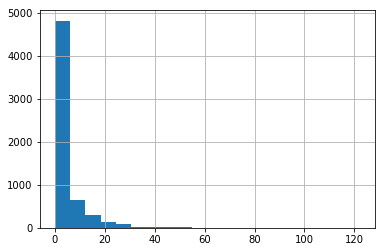

In [3]:
df['lead'][df['lead'] < 125].hist(bins=20)

In [4]:
import os
import glob
import json
import urllib

geodata = {}
for path in glob.glob('../geodata/pittsburgh-water-lead/*.json'):
    key = os.path.splitext(os.path.split(path)[-1])[0]
    with open(path) as fp:
        geodata[key] = json.load(fp)

def get_lat(row):
    address = '{} {}'.format(row['block'], row['street'])
    key = urllib.parse.quote_plus(address)
    data = geodata[key]
    return float(data['OutputGeocodes'][0]['OutputGeocode']['Latitude'])
def get_lon(row):
    address = '{} {}'.format(row['block'], row['street'])
    key = urllib.parse.quote_plus(address)
    data = geodata[key]
    return float(data['OutputGeocodes'][0]['OutputGeocode']['Longitude'])
    
df['lat'] = df.apply(get_lat, axis=1)
df['lon'] = df.apply(get_lon, axis=1)
df['lead_bin'] = pd.cut(df['lead'], [0, 10, 15, df['lead'].max()], include_lowest=True, labels=['<10', '<15', '>=15'])

In [5]:
from bokeh.io import output_notebook, show
from bokeh.models import (
    GMapPlot, GMapOptions, ColumnDataSource, Circle,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, Jitter, Legend, LegendItem
)

In [6]:
plot = GMapPlot(
    x_range=DataRange1d(),
    y_range=DataRange1d(),
    map_options=GMapOptions(lat=40.4406, lng=-79.9959, map_type="roadmap", zoom=12),
)
plot.api_key = os.getenv('GMAPS_API_KEY')

levels = [
    {'bin': '<10', 'color': '#000000'},
    {'bin': '<15', 'color': '#ffff00'},
    {'bin': '>=15', 'color': '#ff0000'},
]
renderers = []
for level in levels:
    circle = Circle(
        x={'field': "lon", 'transform': Jitter(width=0.001)}, 
        y={'field': "lat", 'transform': Jitter(width=0.001)},
        fill_color=level['color'],
        line_color=None,
    )
    renderer = plot.add_glyph(ColumnDataSource(df[df['lead_bin'] == level['bin']]), circle)
    renderers.append(renderer)

legend = Legend(
    items=[LegendItem(label=levels[idx]['bin'], renderers=[renderers[idx]]) for idx in range(len(levels))],
    location='bottom_left',
    orientation='vertical',
    border_line_color='black',
)
plot.add_layout(legend, 'left')
plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())

output_notebook()
show(plot)

Loading BokehJS ...